In [1]:
%cd ..

/home/cole/Documents/dl-final-project


In [2]:
import torch
from PIL import Image
from model.resnet import Prototype
from data import get_labeled_set, get_unlabeled_set, make_bounding_box_images, tensor_to_image, convert_bounding_box_targets

import matplotlib.pyplot as plt
import numpy as np

In [3]:
model = Prototype('cpu')
# model.device = 'cpu'
# model.is_variational = True

file_path = '/home/cole/labeled-roadmap-resnet-latest.torch.dl'
model.load_state_dict(torch.load(file_path, 
                                 map_location=torch.device('cpu')))
model = model.eval()

In [4]:
# _, unlabeled_trainloader = get_unlabeled_set(batch_size=1)
# images, _ = iter(unlabeled_trainloader).next()

In [5]:
# img = images[0]
# img_recon, _, _ = model(img[None, ...], 'single-image')

In [6]:
# plt.imshow(img.numpy().transpose(1, 2, 0))
# plt.axis('off');

In [7]:
# plt.imshow(img_recon[0].detach().numpy().transpose(1, 2, 0))
# plt.axis('off');

In [8]:
(_, labeled_trainloader), (_, labeled_testloader) = get_labeled_set(batch_size=2, validation=0.2)

==> Validation Index: 128


In [9]:
images, targets, road_map = iter(labeled_testloader).next()
images = torch.stack(images)
images.shape

torch.Size([2, 6, 3, 256, 306])

In [10]:
objs_map = model.infer_object_heat_map(images)
objs_map.shape

torch.Size([2, 3, 800, 800])

In [11]:
road_recon_map = model.infer_road_map(images)
road_recon_map.shape

torch.Size([2, 1, 800, 800])

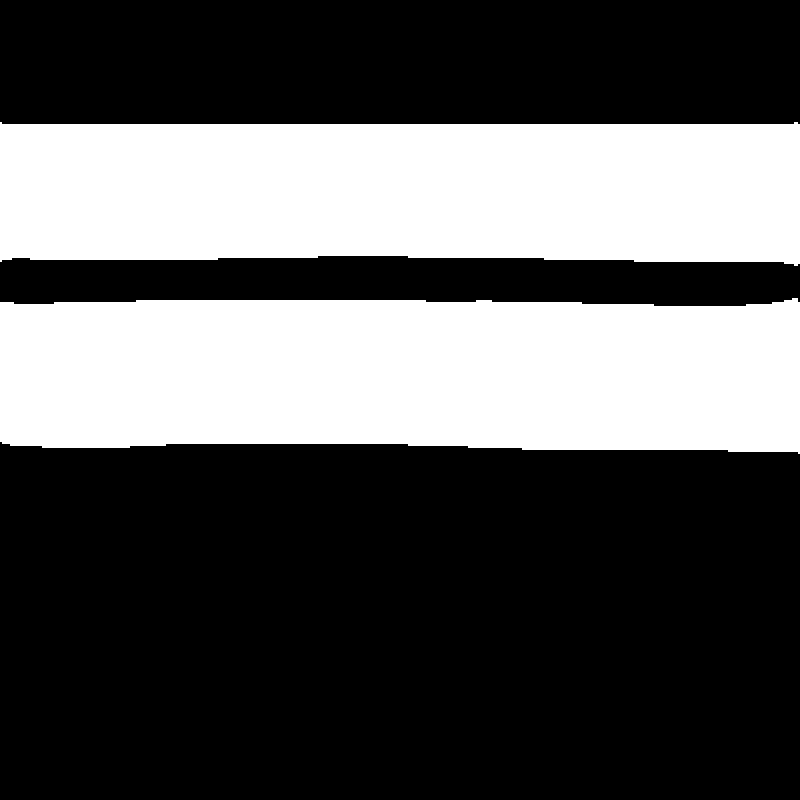

In [12]:
Image.fromarray(road_recon_map[0][0].detach().numpy().astype('bool')).convert('1')

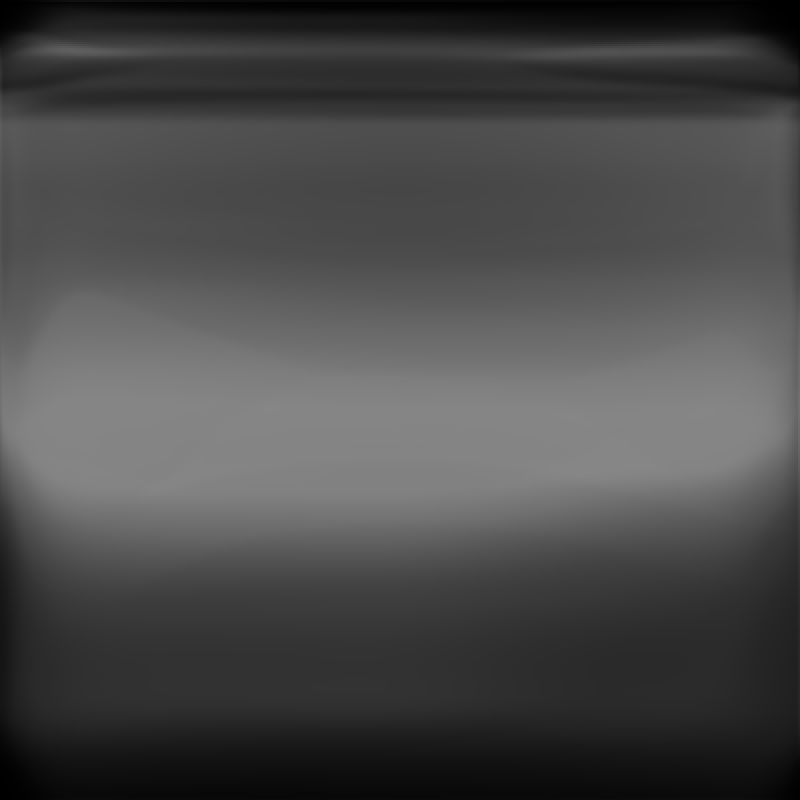

In [13]:
channel = 1
Image.fromarray(objs_map[0][channel].detach().numpy().astype('float') * 255.0).convert('L')

In [14]:
# import matplotlib.pyplot as plt
# from helpers.helper import draw_box
# # The center of image is 400 * 400
# fig, ax = plt.subplots()
# color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
# # ax.imshow(road_image[0], cmap ='binary');
# # The ego car position
# ax.plot(400, 400, 'x', color="red")
# for i, bb in enumerate(targets[0]['bounding_box']):
#     # You can check the implementation of the draw box to understand how it works
#     draw_box(ax, bb, color=color_list[targets[0]['category'][i]])

In [15]:
from model.util import make_object_seg_network_from_backbone

In [17]:
osn = make_object_seg_network_from_backbone(model.backbone, 512, 3)

In [22]:
osn.train()
osn(objs_map, convert_bounding_box_targets(targets))

{'loss_classifier': tensor(1.0996, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0006, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.6931, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(29.0938, grad_fn=<DivBackward0>)}